In [2]:
# Sources used
# https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy?fbclid=IwAR2JWtc6_nC3PZwfg5THA1qjTx1qaLc6NllbXIAftRkZQu_AnQ6VMgaDsIs

In [78]:
# import libraries
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
# get working directory
cwd = os.getcwd()
print(cwd)

C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src


In [3]:
# change working directory to import data
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

In [4]:
metadata_df = pd.read_csv("HAM10000_metadata.csv")
hmnist_8_8_L = pd.read_csv("hmnist_8_8_L.csv")
hmnist_8_8_RGB = pd.read_csv("hmnist_8_8_RGB.csv")
hmnist_28_28_L = pd.read_csv("HAM10000_metadata.csv")
hmnist_28_28_RGB = pd.read_csv("HAM10000_metadata.csv")

In [5]:
# dictionary for image paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

In [6]:
# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

In [7]:
# dictionary to rename cell types for readability
lesion_type_dict = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions ',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Bowens Disease',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

In [8]:
# add column for path of image
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
# add column for cell types, for readability
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)

Exploratory Data Analysis and Data Cleaning

In order to gather an understanding of the data, it was important to run some exploratory data analysis and see things such as the structure of the data and what types the data are stored as.

In [9]:
# print first 5 values of dataframe
print(metadata_df.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                      path                       cell_type  
0  HAM10000_images_part_1\ISIC_0027419.jpg  Benign Keratosis-like Lesions   
1  HAM10000_images_part_1\ISIC_0025030.jpg  Benign Keratosis-like Lesions   
2  HAM10000_images_part_1\ISIC_0026769.jpg  Benign Keratosis-like Lesions   
3  HAM10000_images_part_1\ISIC_0025661.jpg  Benign Keratosis-like Lesions   
4  HAM10000_images_part_2\ISIC_0031633.jpg  Benign Keratosis-like Lesions   


In [10]:
# print first 5 values of dataframe
print(metadata_df.tail(5))

         lesion_id      image_id     dx dx_type   age     sex localization  \
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                          path       cell_type  
10010  HAM10000_images_part_2\ISIC_0033084.jpg  Bowens Disease  
10011  HAM10000_images_part_2\ISIC_0033550.jpg  Bowens Disease  
10012  HAM10000_images_part_2\ISIC_0033536.jpg  Bowens Disease  
10013  HAM10000_images_part_2\ISIC_0032854.jpg  Bowens Disease  
10014  HAM10000_images_part_2\ISIC_0032258.jpg        Melanoma  


In [11]:
# print column names
print(metadata_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type'],
      dtype='object')


In [12]:
# summary of numeric values
print(metadata_df.describe())

               age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000


In [13]:
# gives us data types and how many values of each column are non-null
print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
path            10015 non-null object
cell_type       10015 non-null object
dtypes: float64(1), object(8)
memory usage: 704.3+ KB
None


In [14]:
# fill null values of age with the mean value of the age column
metadata_df["age"] = metadata_df["age"].fillna(int(metadata_df["age"].mean()))

In [15]:
# display unique values in sex column
print(metadata_df.dx.unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [16]:
# display unique values in sex column
print(metadata_df.dx_type.unique())

['histo' 'consensus' 'confocal' 'follow_up']


In [17]:
# display unique values in sex column
print(metadata_df.sex.unique())

['male' 'female' 'unknown']


In [18]:
# drop rows where sex = unknown
metadata_df = metadata_df[metadata_df.sex!='unknown']

In [19]:
# display unique values in sex column
print(metadata_df.localization.unique())

['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [20]:
# drop rows where localization = unknown
metadata_df = metadata_df[metadata_df.localization!='unknown']

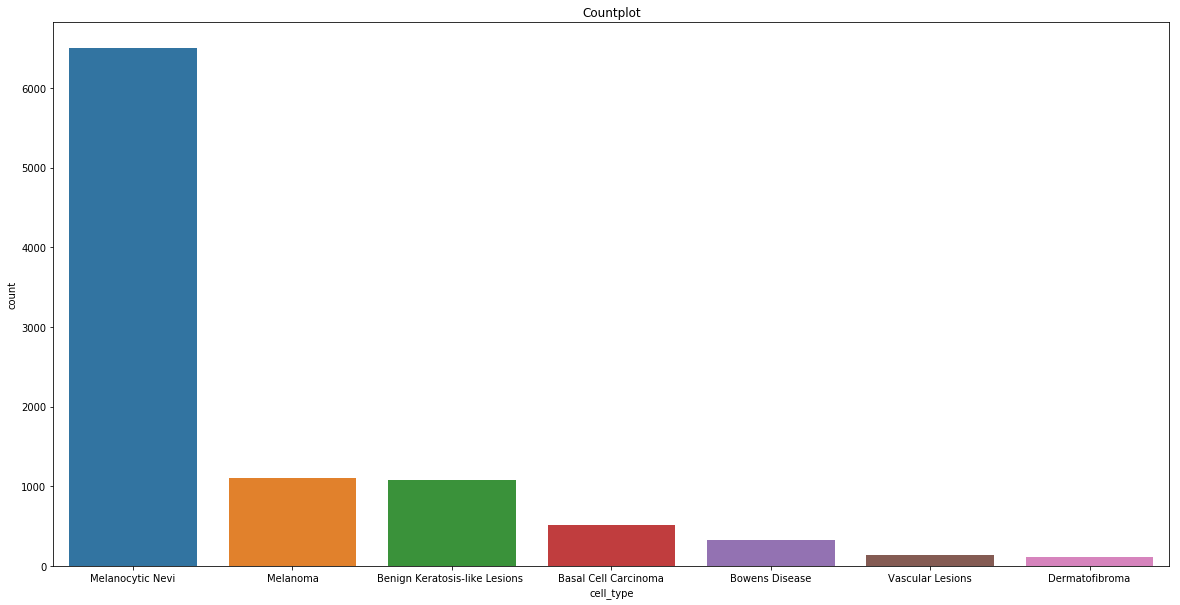

In [21]:
# countplot of cell type
plt.figure(figsize=(20, 10))

sns.countplot(x = 'cell_type',
              data = metadata_df,
              order = metadata_df['cell_type'].value_counts().index)
plt.title("Countplot")
plt.show()

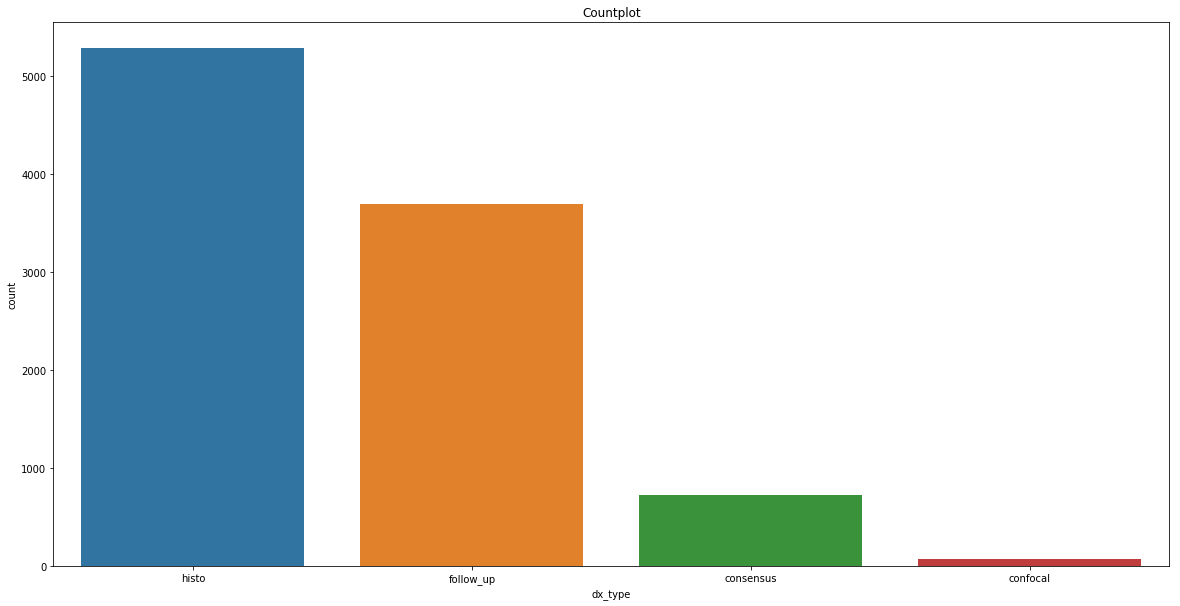

In [22]:
# countplot of diagnosis
plt.figure(figsize=(20, 10))

sns.countplot(x = 'dx_type',
              data = metadata_df,
              order = metadata_df['dx_type'].value_counts().index)
plt.title("Countplot")
plt.show()

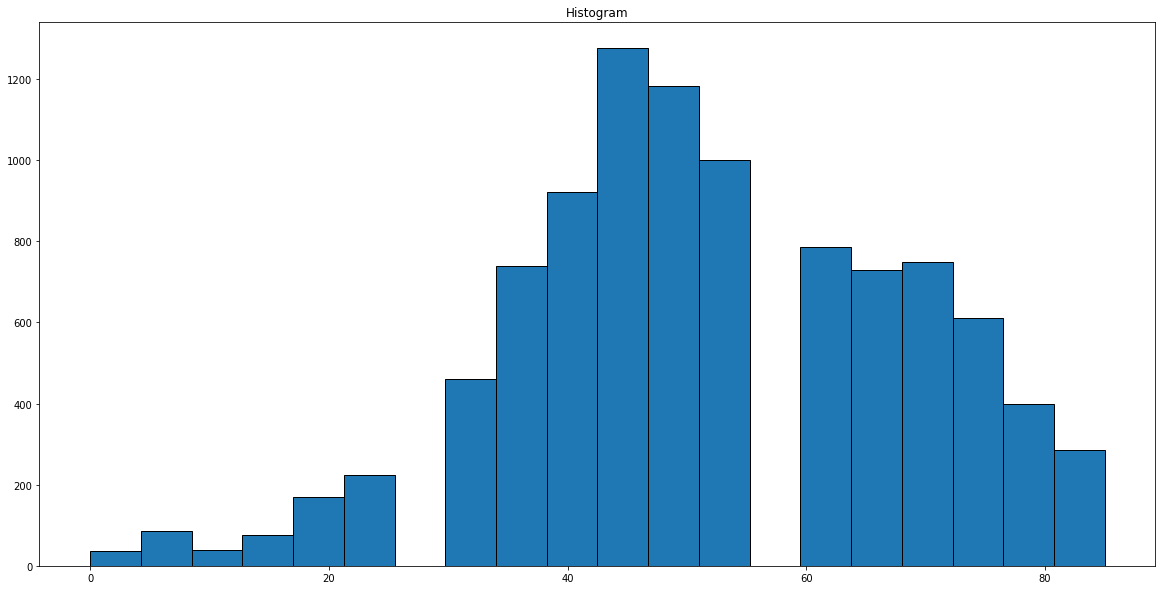

In [23]:
# histogram of age
plt.figure(figsize=(20, 10))

plt.hist(metadata_df['age'], bins = 20, histtype='bar', ec='black')
plt.title("Histogram")
plt.show()

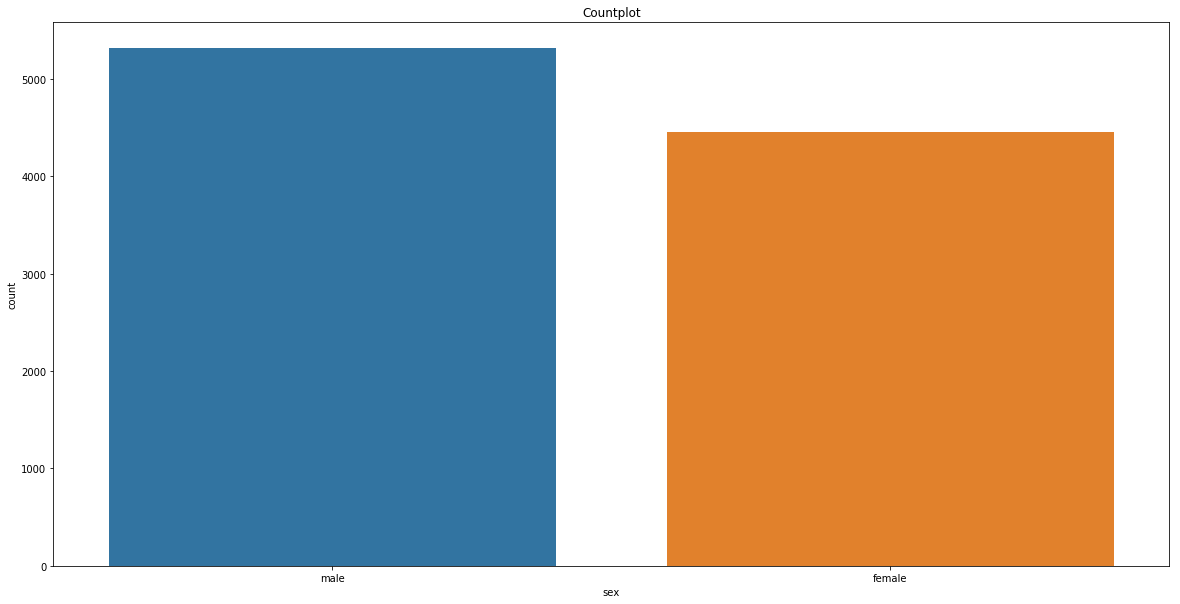

In [24]:
# countplot of sex
plt.figure(figsize=(20, 10))

sns.countplot(x = 'sex',
              data = metadata_df,
              order = metadata_df['sex'].value_counts().index)
plt.title("Countplot")
plt.show()

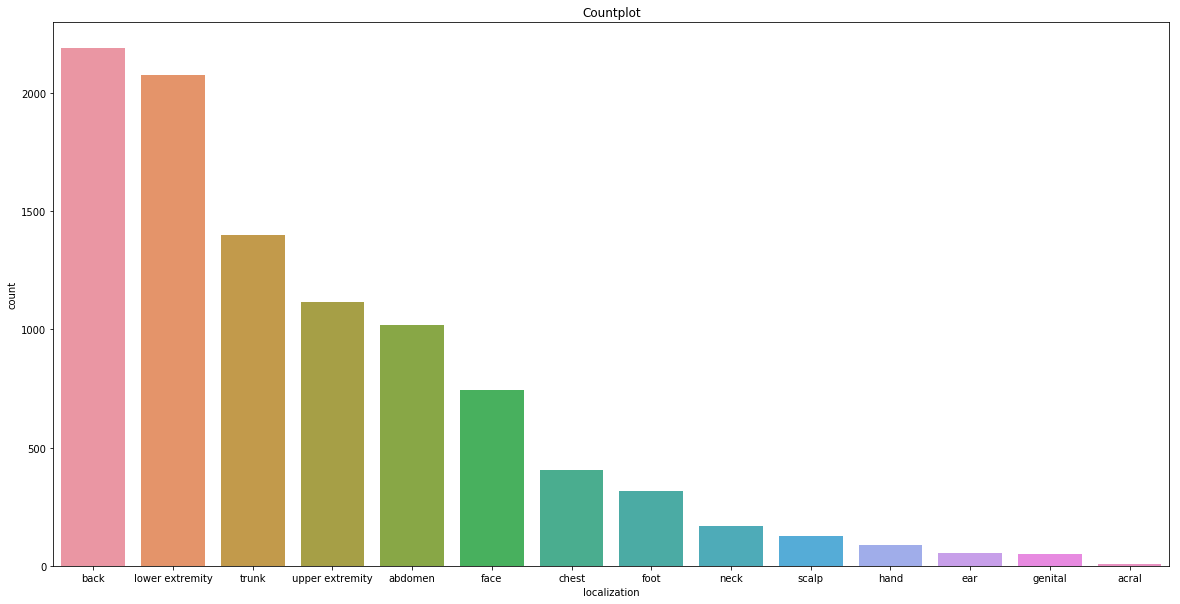

In [25]:
# countplot of loalization
plt.figure(figsize=(20, 10))

sns.countplot(x = 'localization',
              data = metadata_df,
              order = metadata_df['localization'].value_counts().index)
plt.title("Countplot")
plt.show()

In [79]:
# change working directory for resizing
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

# images rescaled to 1/3 of original size
metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((200,150))))

# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

In [80]:
# assign each cell type an ID and add it to a column
metadata_df['cell_type_id'] = pd.Categorical(metadata_df['cell_type']).codes

In [81]:
# get predictor variables and add them to a dataframe
predictor = metadata_df.drop(columns=['cell_type_id'],axis=1)
# get response variables and add them to a series
response = metadata_df['cell_type_id']

In [82]:
# create training and test data for x and y variables at a 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=1)

In [83]:
# normalise data
x_train = np.asarray(x_train["image"].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train = (x_train - np.mean(x_train)) / (np.std(x_train))
x_test = (x_test - np.mean(x_test) / np.std(x_test))

In [84]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [85]:
# split data into training and validation data set at a 70:30 ratio
#x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.3, random_state = 1)

In [86]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(150, 200, 3))
x_test = x_test.reshape(x_test.shape[0], *(150, 200, 3))
#x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [87]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (150, 200, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 150, 200, 32)      896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 150, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 100, 32)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 75, 100, 32)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 75, 100, 64)       18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 100, 64)       36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 50, 64)        0         
__________

In [88]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [89]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [90]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [91]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test, y_test),
                              verbose = 1)

Train on 7328 samples, validate on 2443 samples
Epoch 1/50
7328/7328 [==============================] - 33s 5ms/step - loss: 1.0643 - acc: 0.6627 - val_loss: 1.9293 - val_acc: 0.6259
Epoch 2/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.9314 - acc: 0.6704 - val_loss: 2.5279 - val_acc: 0.6586
Epoch 3/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.8998 - acc: 0.6736 - val_loss: 5.4571 - val_acc: 0.6611
Epoch 4/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.8657 - acc: 0.6818 - val_loss: 5.2532 - val_acc: 0.6533
Epoch 5/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.8523 - acc: 0.6833 - val_loss: 8.7374 - val_acc: 0.1953
Epoch 6/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.8234 - acc: 0.6957 - val_loss: 6.7965 - val_acc: 0.5637
Epoch 7/50
7328/7328 [==============================] - 32s 4ms/step - loss: 0.8021 - acc: 0.7047 - val_loss: 7.3502 - val_acc: 0.5133
Epoch 8